# Astrostatistics and Data Mining-Pset 6
## Ruan Hsuan Wei

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree
from astroML.density_estimation import KDE, KNeighborsDensity
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import cdist, pdist
%matplotlib inline

//anaconda/envs/astro/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/astro/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Problem 1

In [2]:
df = pd.read_csv('COMBO17.csv',sep=',').dropna()

## a)

In [3]:
y=[]
y=(df.S280MAG[df.Mcz<0.3]-df.BjMAG[df.Mcz<0.3])

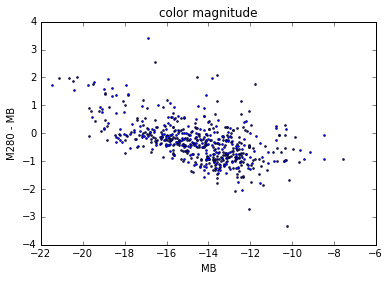

In [4]:
plt.plot(df.BjMAG[df.Mcz<0.3],y,'o',markersize=2)
plt.xlabel("MB")
plt.ylabel("M280 - MB")
plt.title("color magnitude")

## b) KDE, nearest neighbor density estimation

In [5]:
def cross_validation(m1):
    grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.001, 1.0, 100)},
                        cv=20) # 20-fold cross-validation
    grid.fit(m1[:, None])
    print grid.best_params_
    return grid.best_params_

{'bandwidth': 0.55600000000000005}


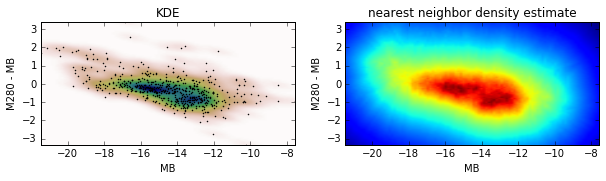

In [6]:
fig,ax= plt.subplots(1,2,figsize=(10, 10))
ax1,ax2=ax

#KDE
m1=np.array(df.BjMAG[df.Mcz<0.3])
m2=np.array(y)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])

kernel = stats.gaussian_kde(values)
band=cross_validation(m1)['bandwidth']
kernel.set_bandwidth(bw_method=(band/np.std(m1,ddof=1)))

Z = np.reshape(kernel(positions).T, X.shape)

ax1.imshow(np.rot90(Z),cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
ax1.plot(m1, m2, 'k.', markersize=2)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])
ax1.set_xlabel("MB")
ax1.set_ylabel("M280 - MB")
ax1.set_title("KDE")

#nearest neighbors density estimate
X=values.T

Nx = 100
Ny = 100
xmin, xmax = (np.min(X[:,0]),np.max(X[:,0]))
ymin, ymax = (np.min(X[:,1]),np.max(X[:,1]))

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),np.linspace(ymin, ymax, Ny)))).T
knn = KNeighborsDensity('simple', 30)
dens = knn.fit(X).eval(Xgrid).reshape((Nx, Ny))

ax2.imshow(np.rot90(np.fliplr(dens.T)), origin='lower',norm=LogNorm(),extent=(xmin, xmax, ymin, ymax))
ax2.set_xlabel("MB")
ax2.set_ylabel("M280 - MB")
ax2.set_title("nearest neighbor density estimate")
plt.show()

We select the appropriate kernel bandwidth by using cross validation method. The bandwidth is optimized through the GridSearchCV function in sklearn package. We choose the k for the nearest-neighbor density estimation to be around 30.  The graph became smoother while k increases. I tried k=5,k=10.... all the way to 40 and there is some significant changes before 30 but not so much after it. From both graphs, we can see two main clusters where the dots are more dense. This could be the red sequence and blue sequence.

## C) k-means

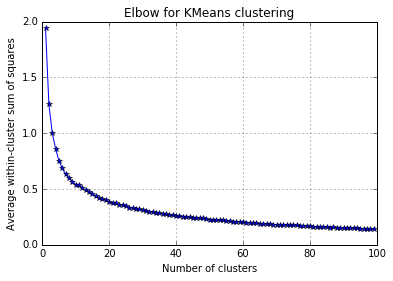

In [9]:
K = range(1,100)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/len(X) for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/len(X)
bss = tss-wcss

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
# plt.ylim(0,2)

We use the Elbow method to calculate the best k for k means clustering. According to the graph, we choose k=3 for our k means clustering because there is no significant big drops after k=3.

In [10]:
XT=values.T
kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(XT)

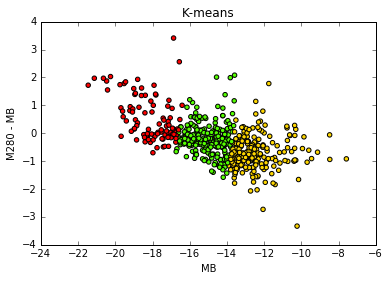

In [11]:
plt.scatter(XT[:,0], XT[:,1], c=kmeans, cmap='prism')  
plt.xlabel("MB")
plt.ylabel("M280 - MB")
plt.title("K-means")

## d) Mean Shift

In [12]:
bandwidth = estimate_bandwidth(XT, quantile=0.3, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(XT)

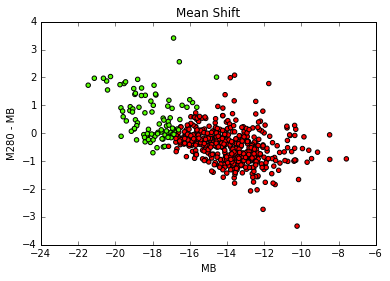

In [13]:
plt.scatter(XT[:,0], XT[:,1], c=ms, cmap='prism')  
plt.xlabel("MB")
plt.ylabel("M280 - MB")
plt.title("Mean Shift")

We select the kernel width by a built-in function called estimate_bandwidth in the sklearn package.It estimates the bandwidth to use with the mean-shift algorithm. Compare to the k means graph, one divides the graph into three clusters while the other divides it into two clusters.

## E) Agglomerative hierarchical clustering

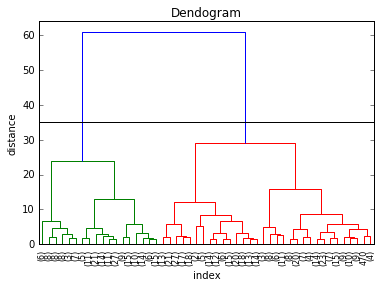

In [14]:
Z = hierarchy.linkage(XT, 'ward')
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=50  )
plt.ylabel("distance")
plt.xlabel("index")
plt.axhline(y=35, c='k')
plt.title("Dendogram")

I would split the graph into 2 clusters. I think cutting the graph into 3 clusters is a little bit unfair to the first two main green clusters since they will be counted as one cluster, but their distance between each other is close to the distance between the two main red clusters which we split into two clusters to form 3 clusters. I think we either split the graph into 2 clusters or 4 clusters. Because the distances within the green cluster itself and the red cluster are relatively smaller than the distance between the green cluster and red cluster, I think it is reasonable to just split the graph into 2 clusters.

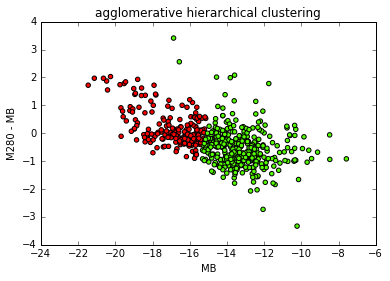

In [15]:
k=2
clusters=fcluster(Z, k, criterion='maxclust')
plt.scatter(XT[:,0], XT[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.xlabel("MB")
plt.ylabel("M280 - MB")
plt.title("agglomerative hierarchical clustering")

Compare to all graphs above, we see that all methods generally divides its graph into 2 to 3 clusters, while the points within each clusters are a little bit different.

# Problem 2

In [16]:
data = np.genfromtxt('pset6.csv',dtype=None,skip_header=1,delimiter=',')

## a)

In [17]:
x1=[]
y1=[]
x2=[]
y2=[]
for i in range(len(data)):
    if data[i][5]==1 :
        x1.append(data[i][0])
        y1.append(data[i][1])
    elif data[i][5]==2:
        x2.append(data[i][0])
        y2.append(data[i][1])

m1=x1+x2
m2=y1+y2

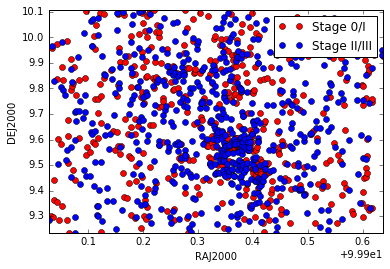

In [18]:
plt.plot(x1,y1,'ro',label="Stage 0/I")
plt.plot(x2,y2,'bo',label="Stage II/III")
plt.xlim(np.min(m1),np.max(m1))
plt.ylim(np.min(m2),np.max(m2))
plt.xlabel("RAJ2000")
plt.ylabel("DEJ2000")
plt.legend()

## b)

{'bandwidth': 0.091818181818181827}


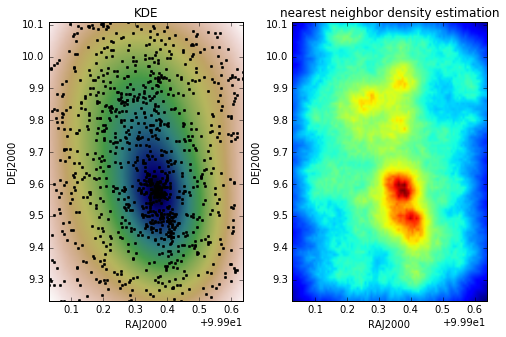

In [19]:
fig,ax= plt.subplots(1,2,figsize=(8, 5))
ax1,ax2=ax

#KDE
m1=np.array(m1)
m2=np.array(m2)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])

kernel = stats.gaussian_kde(values)
band=cross_validation(m1)['bandwidth']
kernel.set_bandwidth(bw_method=band/np.std(m1,ddof=1))

Z = np.reshape(kernel(positions).T, X.shape)

ax1.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
ax1.plot(m1, m2, 'k.', markersize=5)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])
ax1.set_xlabel("RAJ2000")
ax1.set_ylabel("DEJ2000")
ax1.set_title("KDE")

#nearest neighbor density estimation
X=values.T

Nx = 100
Ny = 100
xmin, xmax = (np.min(X[:,0]),np.max(X[:,0]))
ymin, ymax = (np.min(X[:,1]),np.max(X[:,1]))

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

knn5 = KNeighborsDensity('simple', 25)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Nx, Ny))

ax2.imshow(np.rot90(np.fliplr(dens_k5.T)), origin='lower',norm=LogNorm(),
           extent=(xmin, xmax, ymin, ymax))
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymin, ymax])
ax2.set_xlabel("RAJ2000")
ax2.set_ylabel("DEJ2000")
ax2.set_title("nearest neighbor density estimation")

Same as problem 1, I chose the bandwidth for KDE by using the GridSearchCV function in sklearn package to conduct cross validation. I chose the k for the nearest-neighbor density estimation to be around 25. The graph became smoother while k increases. I tried k=5,k=10.... all the way to 30 and there is some significant changes before 25 but not so much after it. Comparing both graphs, we see that while we can kind of see two clusters of dense points using the nearest neighbor density estimation, there is only one main dense part in the middle by using the suggested bandwidth through cross validation. Generally, the big layers of ovals look similar.